# Dependencies

In [2]:
!pip install mne
!pip install scikit_posthocs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.5 MB/s eta 0:00:00


In [3]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
from scipy.signal import welch
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import kruskal
import scikit_posthocs as sp
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import shap
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

## Loading EEG Data from One Session

In this step, we:
- Load EEG data from a single session in the "Complex Mathematical Problem Solving" (CMPS) scenario.
- Select key EEG channels that reflect neural activity from different regions of the scalp.
- Convert the raw EEG signals from volts to microvolts (µV), which is a standard unit in neuroscience.

In [ ]:
edf_path = "/content/drive/MyDrive/datasets/Complex Mathematical Problem solving (CMPS)/1 (1).edf"
raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
eeg_channels = ['AF3', 'T7', 'Pz', 'T8', 'AF4']
raw.pick(eeg_channels)
eeg_data, times = raw[:]
eeg_data_uv = eeg_data * 1e6 # convert to micro
sampling_rate = int(raw.info['sfreq'])

In [10]:
edf_path = "/content/drive/MyDrive/datasets/Complex Mathematical Problem solving (CMPS)/1 (2).edf"
raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

# Load all channels (no picking)
eeg_data, times = raw[:]
eeg_data_uv = eeg_data * 1e6  # Convert to microvolts

# Find and extract 'T7'
channel_names = ['CQ_AF3']
for channel_name in channel_names:
  channel_index = raw.ch_names.index(channel_name)
  channel_data = eeg_data_uv[channel_index]

  #for data in channel_data:
    #if data != 0:
      #print(f"{channel_name}: {data}")
  #print(f"Data for channel {channel_name} (first 20000 samples):")
  print(channel_data[:1000])

[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.

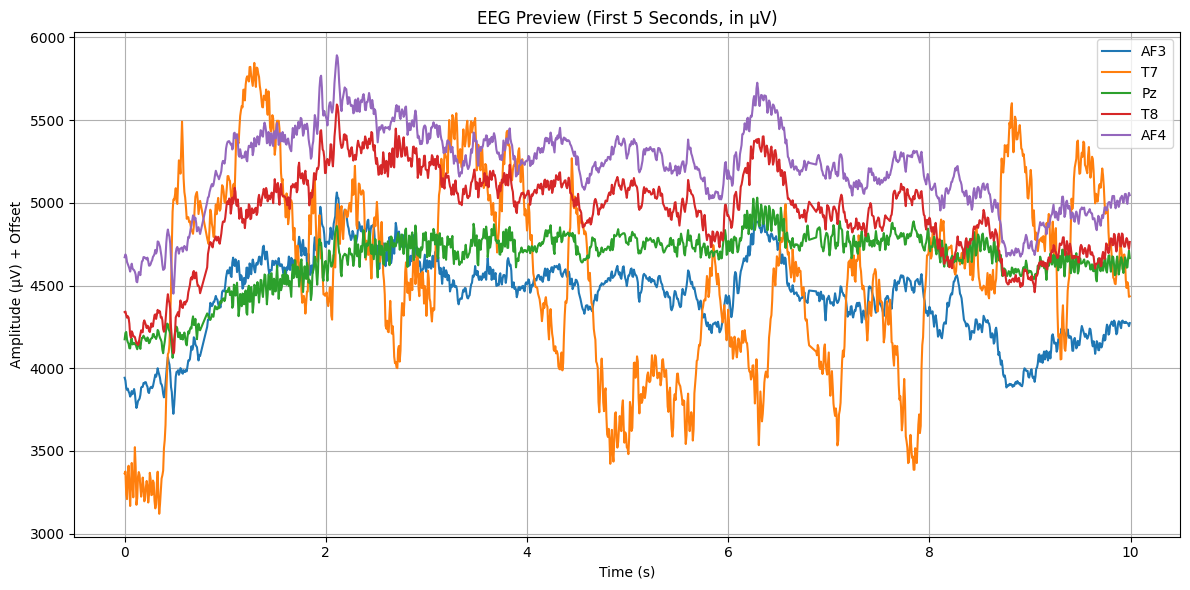

In [ ]:
duration_sec = 10
num_points = sampling_rate * duration_sec
segment_uv = eeg_data_uv[:, :num_points]
time_axis = np.arange(num_points) / sampling_rate
plt.figure(figsize=(12, 6))
for i, ch in enumerate(eeg_channels):
    plt.plot(time_axis, segment_uv[i] + i * 200, label=ch)  # offset for clarity
plt.title("EEG Preview (First 5 Seconds, in µV)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV) + Offset")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
cmps_raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
marker_channels = ['MarkerType', 'MarkerValueInt', 'MARKER_HARDWARE']
marker_data = cmps_raw.copy().pick(marker_channels)
marker_values, marker_times = marker_data[:]
marker_df = pd.DataFrame(
    data=marker_values.T[:20],
    columns=marker_channels
)
marker_df["Time (s)"] = marker_times[:20]
display(marker_df)

,MarkerType,MarkerValueInt,MARKER_HARDWARE,Time (s)
0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.007812
2,0.0,0.0,0.0,0.015625
3,0.0,0.0,0.0,0.023438
4,0.0,0.0,0.0,0.031250
5,0.0,0.0,0.0,0.039062
6,0.0,0.0,0.0,0.046875
7,0.0,0.0,0.0,0.054688
8,0.0,0.0,0.0,0.062500
9,0.0,0.0,0.0,0.070312


After checking for unique markers, we can divide the EEG data into segments based on marker duration. In this particular dataset, we get three segments.

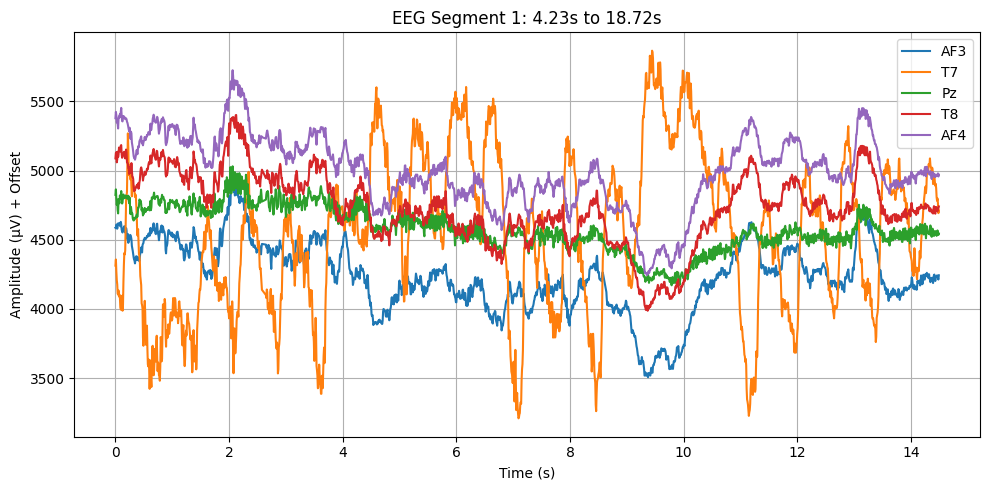

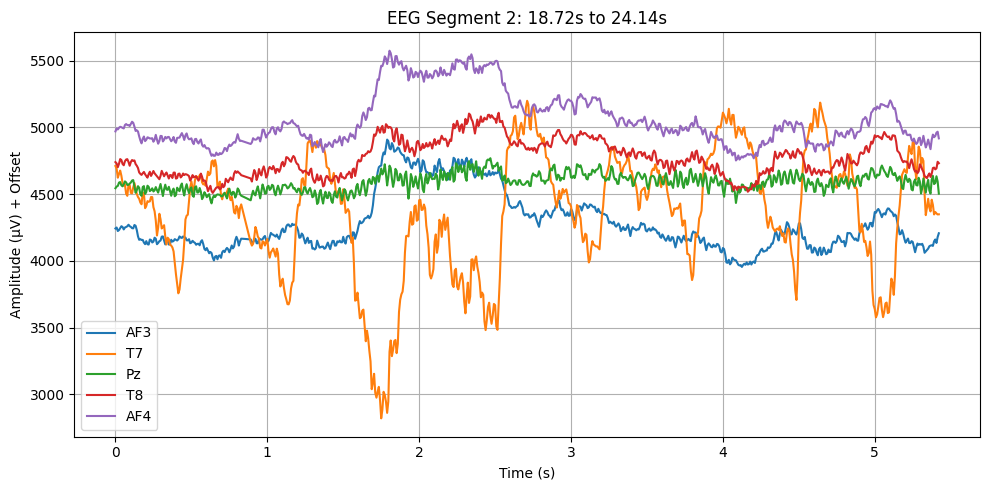

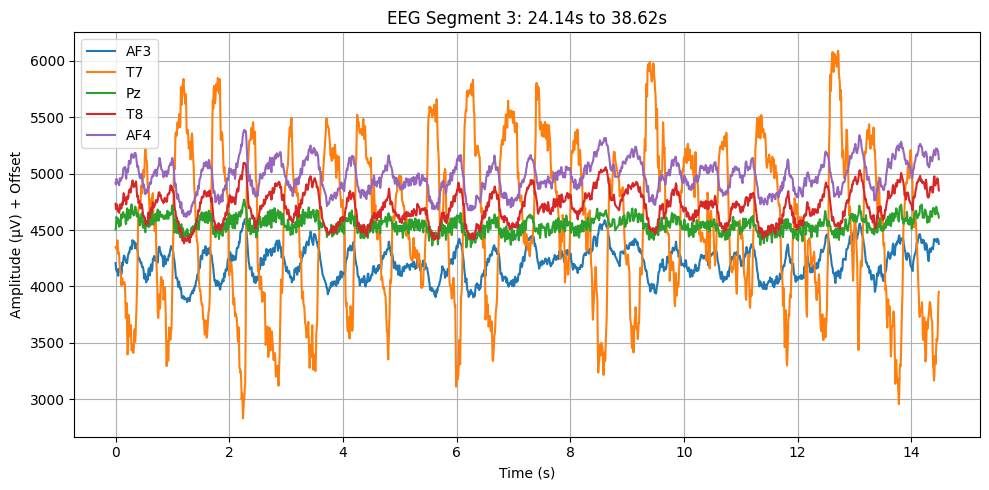

In [ ]:
non_zero_indices = (marker_values != 0).any(axis=0).nonzero()[0]
segment_times = marker_times[non_zero_indices]
segment_pairs = list(zip(segment_times[:-1], segment_times[1:]))
for i, (start, end) in enumerate(segment_pairs, 1):
    segment = raw.copy().crop(tmin=start, tmax=end)
    data, times = segment[:]
    data_uv = data * 1e6  # convert to µV
    plt.figure(figsize=(10, 5))
    time_axis = np.arange(data_uv.shape[1]) / raw.info['sfreq']
    for ch in range(data_uv.shape[0]):
        plt.plot(time_axis, data_uv[ch] + ch * 200, label=eeg_channels[ch])
    plt.title(f"EEG Segment {i}: {start:.2f}s to {end:.2f}s")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV) + Offset")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
base_dir = "/content/drive/MyDrive/datasets/"
sampling_rates = {}
for scenario in os.listdir(base_dir):
    scenario_path = os.path.join(base_dir, scenario)
    if not os.path.isdir(scenario_path):
        continue

    for file in os.listdir(scenario_path):
        if file.lower().endswith(".edf"):
            file_path = os.path.join(scenario_path, file)
            try:
                raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
                sfreq = raw.info['sfreq']
                key = f"{scenario}/{file}"
                sampling_rates[key] = sfreq
            except Exception as e:
                print(f"Failed to read {file}: {e}")
sr_df = pd.DataFrame(list(sampling_rates.items()), columns=["File", "Sampling Rate (Hz)"])
unique_rates = sr_df["Sampling Rate (Hz)"].unique()
print(f"Unique Sampling Rates Found: {unique_rates}")
display(sr_df)

Unique Sampling Rates Found: [128.]


,File,Sampling Rate (Hz)
0,Participants Listening to Relaxing Music/001 (...,128.0
1,Participants Listening to Relaxing Music/001 (...,128.0
2,Participants Listening to Relaxing Music/001 (...,128.0
3,Participants Listening to Relaxing Music/001 (...,128.0
4,Participants Listening to Relaxing Music/001 (...,128.0
...,...,...
107,Horrer Video Stimulation/002 (20).edf,128.0
108,Horrer Video Stimulation/002 (11).edf,128.0
109,Horrer Video Stimulation/002 (15).edf,128.0
110,Horrer Video Stimulation/002 (10).edf,128.0


In [ ]:
checks = []
expected_eeg_channels = eeg_channels
required_marker_channels = marker_channels
min_duration_sec = 10

for scenario in os.listdir(base_dir):
    scenario_path = os.path.join(base_dir, scenario)
    if not os.path.isdir(scenario_path):
        continue
    for file in os.listdir(scenario_path):
        if not file.lower().endswith(".edf"):
            continue
        file_path = os.path.join(scenario_path, file)
        raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
        ch_names = raw.ch_names
        duration = raw.times[-1]
        channels_ok = all(ch in ch_names for ch in expected_eeg_channels)
        markers_ok = all(ch in ch_names for ch in required_marker_channels)
        long_enough = duration >= min_duration_sec

        checks.append({
                "File": f"{scenario}/{file}",
                "Has All EEG Channels": channels_ok,
                "Has Markers": markers_ok,
                "Duration >= 10s": long_enough,
                "Duration (s)": round(duration, 2),
                "Missing EEG Channels": [ch for ch in expected_eeg_channels if ch not in ch_names],
                "Missing Marker Channels": [ch for ch in required_marker_channels if ch not in ch_names]
        })

check_df = pd.DataFrame(checks)
display(check_df)

,File,Has All EEG Channels,Has Markers,Duration >= 10s,Duration (s),Missing EEG Channels,Missing Marker Channels
0,Participants Listening to Relaxing Music/001 (...,True,True,True,65.99,[],[]
1,Participants Listening to Relaxing Music/001 (...,True,True,True,121.99,[],[]
2,Participants Listening to Relaxing Music/001 (...,True,True,True,184.99,[],[]
3,Participants Listening to Relaxing Music/001 (...,True,True,True,103.99,[],[]
4,Participants Listening to Relaxing Music/001 (...,True,True,True,200.99,[],[]
...,...,...,...,...,...,...,...
107,Horrer Video Stimulation/002 (20).edf,True,True,True,111.99,[],[]
108,Horrer Video Stimulation/002 (11).edf,True,True,True,162.99,[],[]
109,Horrer Video Stimulation/002 (15).edf,True,True,True,56.99,[],[]
110,Horrer Video Stimulation/002 (10).edf,True,True,True,98.99,[],[]


In [ ]:
total_files = len(check_df)
channels_ok_count = check_df["Has All EEG Channels"].sum()
markers_ok_count = check_df["Has Markers"].sum()
duration_ok_count = check_df["Duration >= 10s"].sum()

print(f"\nValidation Summary")
print(f"Total files checked: {total_files}")
print(f"Files with all EEG channels: {channels_ok_count} / {total_files}")
print(f"Files with marker channels: {markers_ok_count} / {total_files}")
print(f"Files ≥ 10s long: {duration_ok_count} / {total_files}")

# Show failing files per issue
for col in ["Has All EEG Channels", "Has Markers", "Duration >= 10s"]:
    failed = check_df[~check_df[col]]
    if not failed.empty:
        print(f"\nFiles failing '{col}':")
        for f in failed["File"]:
            print(f"  - {f}")


Validation Summary
Total files checked: 112
Files with all EEG channels: 112 / 112
Files with marker channels: 112 / 112
Files ≥ 10s long: 112 / 112


# Organization

- Here, we funnel all the data from various sessions into one CSV file.
- Each scenario is converted into a categorical variable belonging to a feature.
- For preservation, each user's ID will be referenced with each row.

In [ ]:
base_dir = "/content/drive/MyDrive/datasets/"
eeg_channels = ['AF3', 'T7', 'Pz', 'T8', 'AF4']
marker_channels = ['MarkerType', 'MarkerValueInt', 'MARKER_HARDWARE']
cq_channels = ['CQ_AF3', 'CQ_T7', 'CQ_Pz', 'CQ_T8', 'CQ_AF4', 'CQ_OVERALL']
eq_channels = ['EQ_AF3', 'EQ_T7', 'EQ_Pz', 'EQ_T8', 'EQ_AF4', 'EQ_OVERALL']
battery_channels = ['BATTERY', 'BATTERY_PERCENT']
quality_channels = cq_channels + eq_channels
bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 45),
}
band_cols = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
sampling_rate = 128
all_feature_rows = []

| **Band** | **Frequency** | **Mental State / Interpretation** | **Common Regions** |
|----------|---------------|-----------------------------------|--------------------|
| **Delta** | 1–4 Hz | Deep sleep, unconscious states, drowsiness | Frontal cortex |
| **Theta** | 4–8 Hz | Drowsiness, relaxation, daydreaming, **working memory** | Frontal/temporal |
| **Alpha** | 8–13 Hz | **Relaxation**, calm wakefulness, **idling brain** | Occipital/parietal |
| **Beta** | 13–30 Hz | Active thinking, **cognitive load**, problem-solving | Frontal cortex |
| **Gamma** | 30–45+ Hz | **High-level cognition**, attention, consciousness | All over, often frontal & sensory |


In [ ]:
for scenario_name in os.listdir(base_dir):
    scenario_path = os.path.join(base_dir, scenario_name)
    if not os.path.isdir(scenario_path):
        continue

    for file in os.listdir(scenario_path):
        if not file.lower().endswith(".edf"):
            continue
        edf_path = os.path.join(scenario_path, file)
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        raw_eeg = raw.copy().pick(eeg_channels)
        raw_eeg.filter(1., 40., verbose=False)
        marker_data = raw.copy().pick(marker_channels)
        marker_values, marker_times = marker_data[:]
        non_zero_indices = (marker_values != 0).any(axis=0).nonzero()[0]
        marker_event_times = marker_times[non_zero_indices]
        if len(marker_event_times) < 2:
            continue
        segment_pairs = list(zip(marker_event_times[:-1], marker_event_times[1:]))
        quality_data = raw.copy().pick(quality_channels)
        quality_vals, quality_times = quality_data[:]
        battery_data = raw.copy().pick(battery_channels)
        battery_vals, battery_times = battery_data[:]
        for seg_idx, (start, end) in enumerate(segment_pairs, start=1):
            segment = raw_eeg.copy().crop(tmin=start, tmax=end)
            data, _ = segment[:]
            data_uv = data * 1e6
            quality_idx = (quality_times >= start) & (quality_times <= end)
            battery_idx = (battery_times >= start) & (battery_times <= end)
            for ch_idx, ch_data in enumerate(data_uv):
                freqs, psd = welch(ch_data, fs=sampling_rate, nperseg=256)
                band_powers = {
                    band: psd[(freqs >= low) & (freqs <= high)].mean()
                    for band, (low, high) in bands.items()
                }
                row = {
                    "Participant": os.path.splitext(file)[0].replace(" ", "_"),
                    "Scenario": scenario_name,
                    "Segment": f"Segment_{seg_idx}",
                    "Channel": eeg_channels[ch_idx],
                    **band_powers
                }
                for q_idx, q_name in enumerate(quality_channels):
                    segment_q = quality_vals[q_idx, quality_idx]
                    row[f"{q_name}_mean"] = np.mean(segment_q)
                    row[f"{q_name}_std"] = np.std(segment_q)
                for b_idx, b_name in enumerate(battery_channels):
                    segment_b = battery_vals[b_idx, battery_idx]
                    row[f"{b_name}_mean"] = np.mean(segment_b)
                    row[f"{b_name}_std"] = np.std(segment_b)

                all_feature_rows.append(row)
df = pd.DataFrame(all_feature_rows)
df.to_csv("/content/drive/MyDrive/output/all_participants_features.csv", index=False)
print("All features saved to: all_participants_features.csv")

All features saved to: all_participants_features.csv


# Distribution inspection

<ipython-input-42-a52878c436e5>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


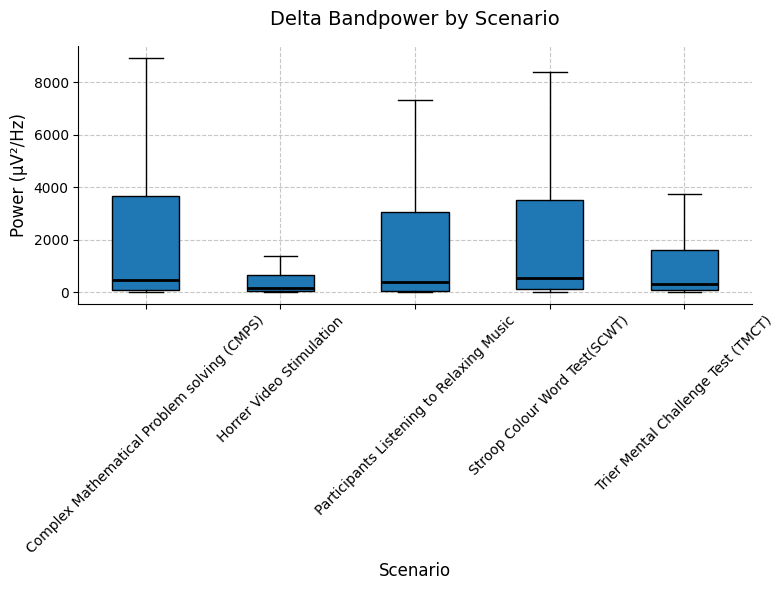

<ipython-input-42-a52878c436e5>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


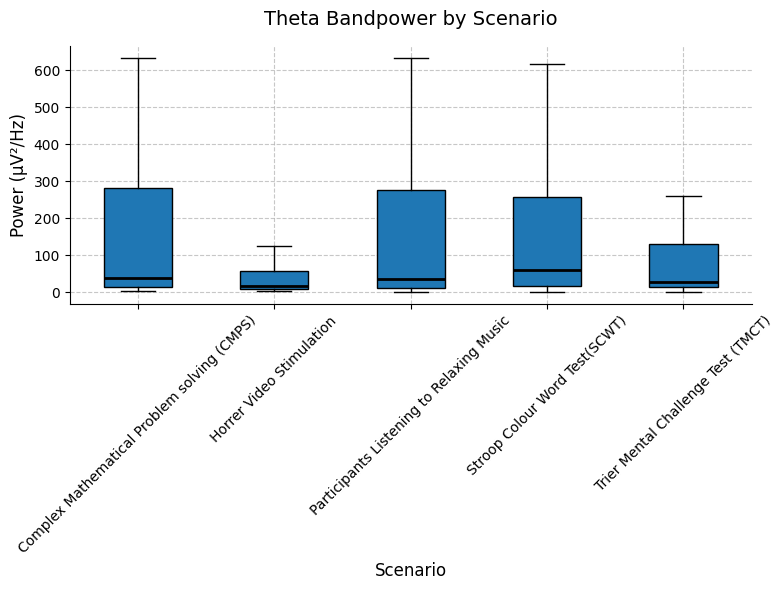

<ipython-input-42-a52878c436e5>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


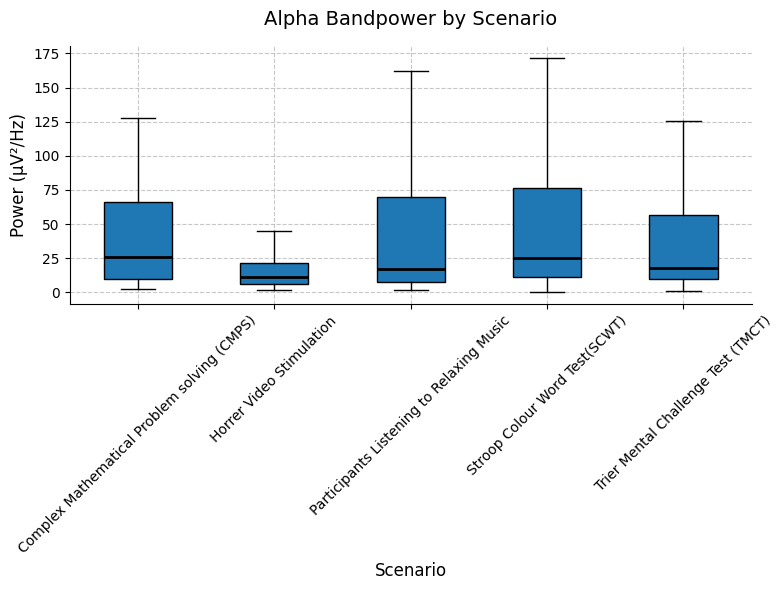

<ipython-input-42-a52878c436e5>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


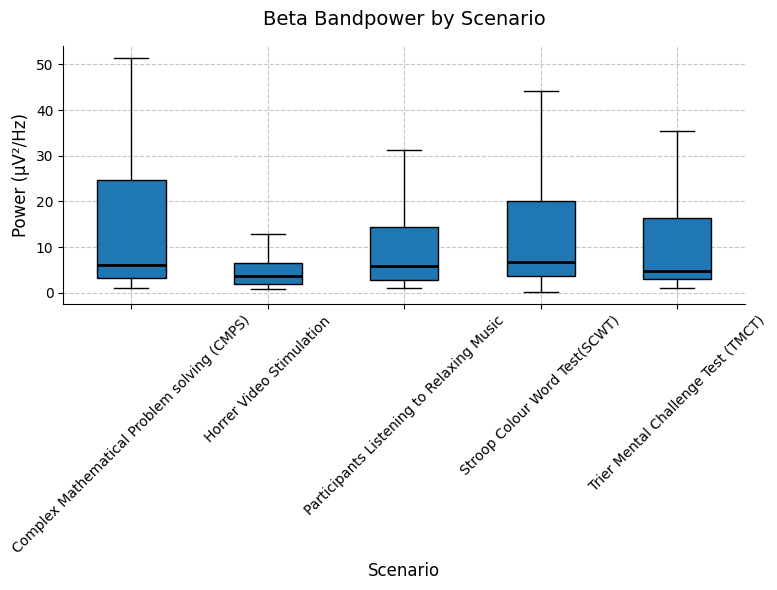

<ipython-input-42-a52878c436e5>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


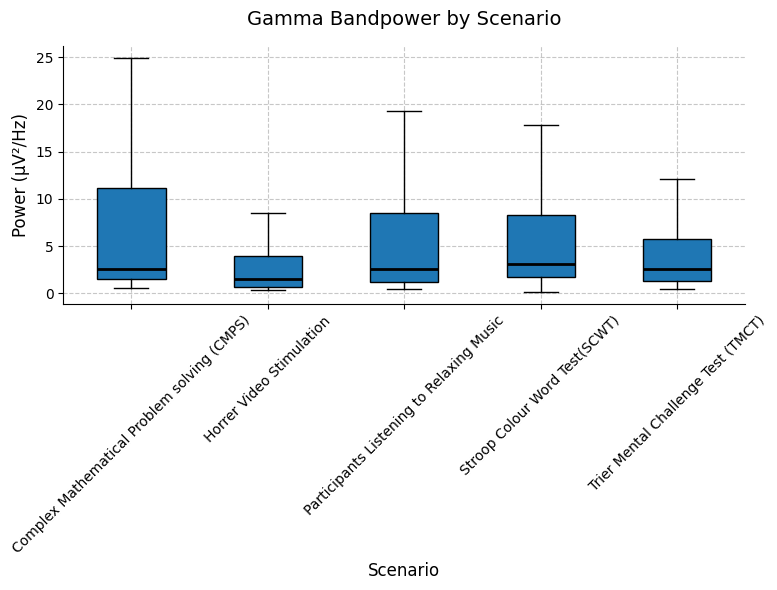

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/output/all_participants_features.csv")
bands = band_cols
scenarios = sorted(df["Scenario"].unique())
def boxplots(df):
    for band in bands:
        data_by_scenario = [df[df["Scenario"] == scenario][band].dropna() for scenario in scenarios]
        fig, ax = plt.subplots(figsize=(8, 6))
        bp = ax.boxplot(
            data_by_scenario,
            labels=scenarios,
            patch_artist=True,
            showfliers=False,
            medianprops={"linewidth": 2, "color": "black"}
        )
        ax.set_title(f"{band} Bandpower by Scenario", fontsize=14, pad=15)
        ax.set_xlabel("Scenario", fontsize=12)
        ax.set_ylabel("Power (µV²/Hz)", fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.7)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
boxplots(df)

## Cleaning Outliers

In [ ]:
outlier_summary = []
for band in band_cols:
    Q1 = df[band].quantile(0.25)
    Q3 = df[band].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = ((df[band] < lower) | (df[band] > upper)).sum()
    total = len(df)
    percent = 100 * outliers / total

    outlier_summary.append({
        "Band": band,
        "Outliers": outliers,
        "Total": total,
        "Percent": round(percent, 2)
    })
outlier_df = pd.DataFrame(outlier_summary)
print("Outlier Summary (IQR Method):")
display(outlier_df)

Outlier Summary (IQR Method):


,Band,Outliers,Total,Percent
0,Delta,240,1530,15.69
1,Theta,251,1530,16.41
2,Alpha,211,1530,13.79
3,Beta,234,1530,15.29
4,Gamma,209,1530,13.66


In [ ]:
df_winsor = df.copy()
def winsorize_column(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower=lower, upper=upper)
for band in bands:
    df_winsor[band] = winsorize_column(df_winsor[band])
df_winsor.to_csv("/content/drive/MyDrive/output/winsorized_bandpower_features.csv", index=False)
print("Winsorized data saved as: winsorized_bandpower_features.csv")

Winsorized data saved as: winsorized_bandpower_features.csv


<ipython-input-42-a52878c436e5>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


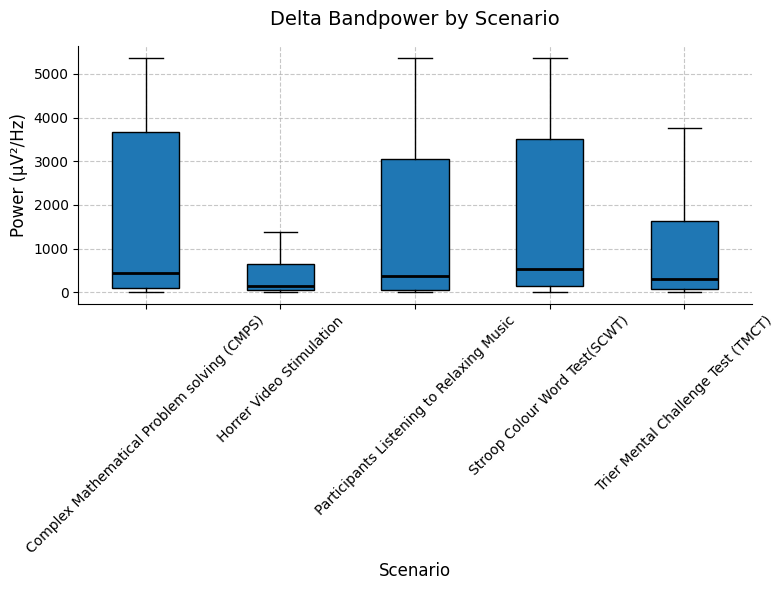

<ipython-input-42-a52878c436e5>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


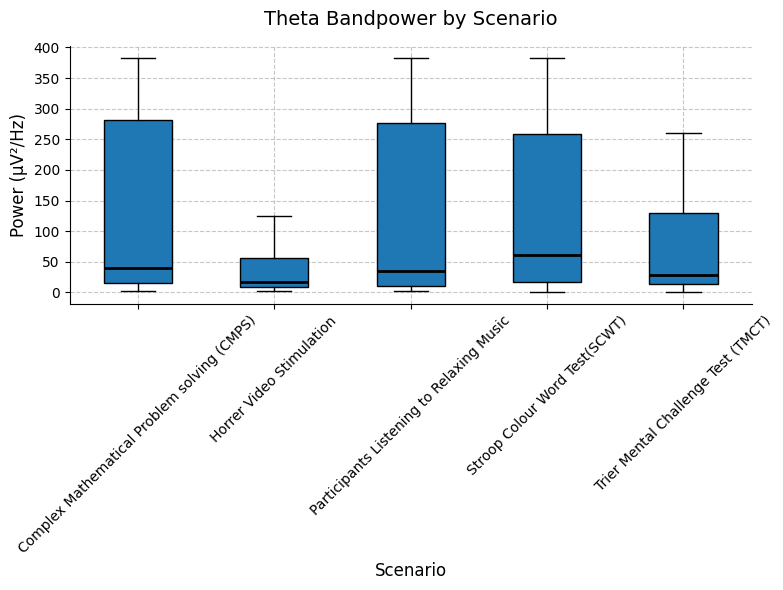

<ipython-input-42-a52878c436e5>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


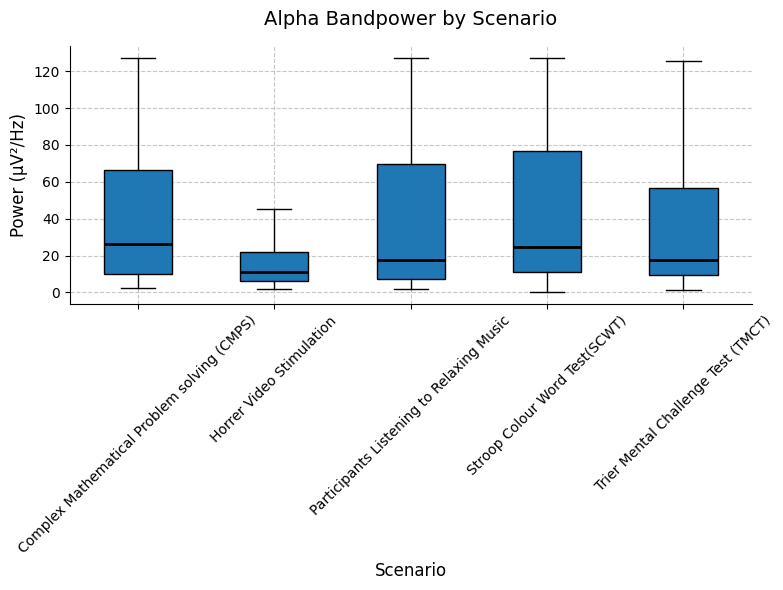

<ipython-input-42-a52878c436e5>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


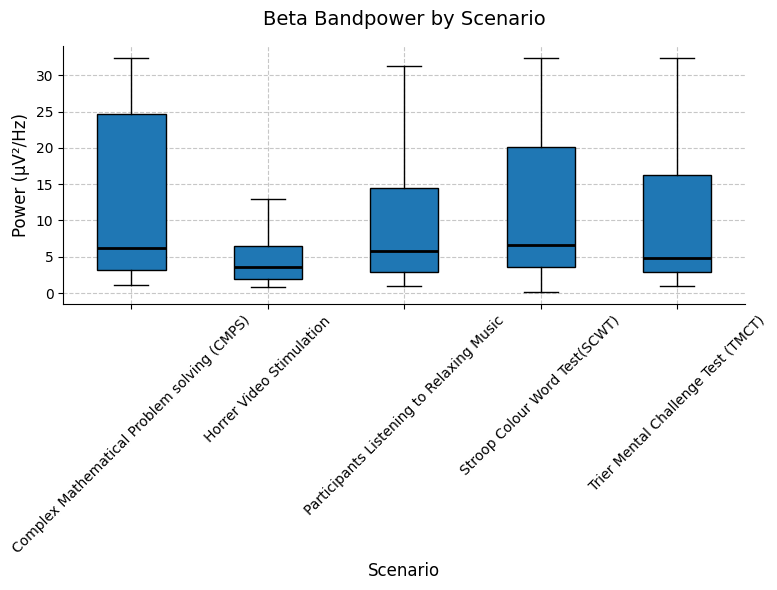

<ipython-input-42-a52878c436e5>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


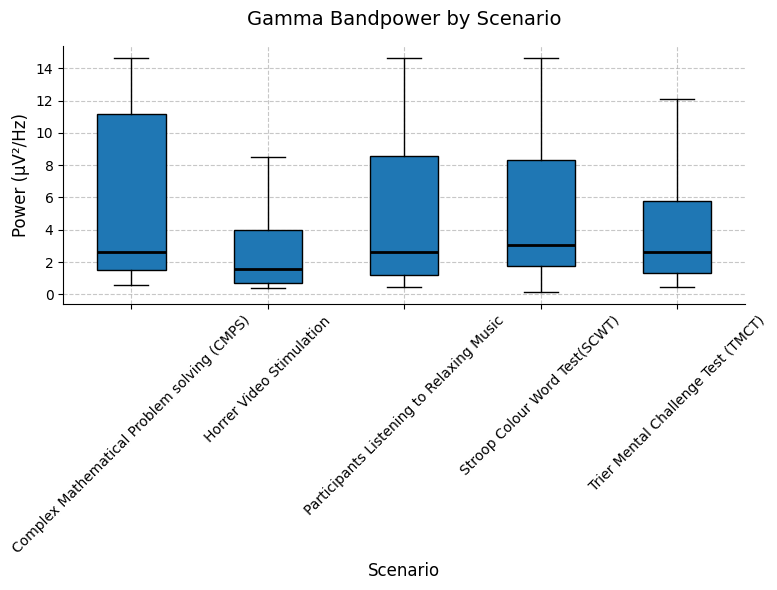

In [ ]:
df_winsorized = pd.read_csv("/content/drive/MyDrive/output/winsorized_bandpower_features.csv")
boxplots(df_winsorized)

In [ ]:
def check_normality(df, features, group_col="Scenario", alpha=0.05):
    results = []
    for feature in features:
        for group in df[group_col].unique():
            data = df[df[group_col] == group][feature].dropna()
            if len(data) >= 3:
                stat, p = shapiro(data)
                normal = p > alpha
                results.append({
                    "Feature": feature,
                    "Group": group,
                    "N": len(data),
                    "W-Statistic": stat,
                    "p-Value": p,
                    "Normal?": "Yes" if normal else "No"
                })
    return pd.DataFrame(results)
normality_df = check_normality(df_winsorized, bands)
display(normality_df)

,Feature,Group,N,W-Statistic,p-Value,Normal?
0,Delta,Participants Listening to Relaxing Music,240,0.694552,1.254267e-20,No
1,Delta,Trier Mental Challenge Test (TMCT),360,0.684343,2.123620e-25,No
2,Delta,Stroop Colour Word Test(SCWT),360,0.722217,4.786322e-24,No
3,Delta,Complex Mathematical Problem solving (CMPS),315,0.724829,1.822211e-22,No
4,Delta,Horrer Video Stimulation,255,0.584144,2.532269e-24,No
5,Theta,Participants Listening to Relaxing Music,240,0.713753,5.073081e-20,No
6,Theta,Trier Mental Challenge Test (TMCT),360,0.683731,2.024355e-25,No
7,Theta,Stroop Colour Word Test(SCWT),360,0.744178,3.395354e-23,No
8,Theta,Complex Mathematical Problem solving (CMPS),315,0.718025,1.036892e-22,No
9,Theta,Horrer Video Stimulation,255,0.598331,5.759628e-24,No


Tests such as ANOVA are off the table as they aren't even close to being normally distributed.

## Unwrapping the Story

In [ ]:
def kruskal_and_dunn(df, features, group_col="Scenario"):
    results = []
    dunn_matrices = {}
    for feature in features:
        group_data = [df[df[group_col] == g][feature].dropna() for g in df[group_col].unique()]
        stat, p = kruskal(*group_data)

        results.append({
            "Feature": feature,
            "Test": "Kruskal-Wallis",
            "p-Value": p,
            "Significant?": "Yes" if p < 0.05 else "No"
        })
        if p < 0.05:
            dunn_df = sp.posthoc_dunn(df, val_col=feature, group_col=group_col, p_adjust='bonferroni')
            dunn_matrices[feature] = dunn_df
            print(f"\nDunn's post-hoc for {feature} (only showing p < 0.05):")
            display(dunn_df[dunn_df < 0.05])

    return pd.DataFrame(results), dunn_matrices
bands = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
kruskal_df, dunn_dict = kruskal_and_dunn(df_winsorized, bands)


Dunn's post-hoc for Delta (only showing p < 0.05):


,Complex Mathematical Problem solving (CMPS),Horrer Video Stimulation,Participants Listening to Relaxing Music,Stroop Colour Word Test(SCWT),Trier Mental Challenge Test (TMCT)
Complex Mathematical Problem solving (CMPS),NaN,1.190724e-08,NaN,NaN,NaN
Horrer Video Stimulation,1.190724e-08,NaN,0.001836,8.685931e-11,0.000644
Participants Listening to Relaxing Music,NaN,1.836202e-03,NaN,NaN,NaN
Stroop Colour Word Test(SCWT),NaN,8.685931e-11,NaN,NaN,0.018802
Trier Mental Challenge Test (TMCT),NaN,6.442212e-04,NaN,1.880238e-02,NaN



Dunn's post-hoc for Theta (only showing p < 0.05):


,Complex Mathematical Problem solving (CMPS),Horrer Video Stimulation,Participants Listening to Relaxing Music,Stroop Colour Word Test(SCWT),Trier Mental Challenge Test (TMCT)
Complex Mathematical Problem solving (CMPS),NaN,1.018434e-08,NaN,NaN,NaN
Horrer Video Stimulation,1.018434e-08,NaN,0.000074,2.513130e-13,0.000109
Participants Listening to Relaxing Music,NaN,7.401868e-05,NaN,NaN,NaN
Stroop Colour Word Test(SCWT),NaN,2.513130e-13,NaN,NaN,0.004020
Trier Mental Challenge Test (TMCT),NaN,1.089187e-04,NaN,4.020108e-03,NaN



Dunn's post-hoc for Alpha (only showing p < 0.05):


,Complex Mathematical Problem solving (CMPS),Horrer Video Stimulation,Participants Listening to Relaxing Music,Stroop Colour Word Test(SCWT),Trier Mental Challenge Test (TMCT)
Complex Mathematical Problem solving (CMPS),NaN,9.475906e-13,NaN,NaN,NaN
Horrer Video Stimulation,9.475906e-13,NaN,0.000054,8.550392e-16,8.557983e-09
Participants Listening to Relaxing Music,NaN,5.410981e-05,NaN,1.088152e-02,NaN
Stroop Colour Word Test(SCWT),NaN,8.550392e-16,0.010882,NaN,NaN
Trier Mental Challenge Test (TMCT),NaN,8.557983e-09,NaN,NaN,NaN



Dunn's post-hoc for Beta (only showing p < 0.05):


,Complex Mathematical Problem solving (CMPS),Horrer Video Stimulation,Participants Listening to Relaxing Music,Stroop Colour Word Test(SCWT),Trier Mental Challenge Test (TMCT)
Complex Mathematical Problem solving (CMPS),NaN,4.792856e-14,NaN,NaN,NaN
Horrer Video Stimulation,4.792856e-14,NaN,1.369468e-08,3.115191e-18,5.249538e-08
Participants Listening to Relaxing Music,NaN,1.369468e-08,NaN,NaN,NaN
Stroop Colour Word Test(SCWT),NaN,3.115191e-18,NaN,NaN,5.987200e-03
Trier Mental Challenge Test (TMCT),NaN,5.249538e-08,NaN,5.987200e-03,NaN



Dunn's post-hoc for Gamma (only showing p < 0.05):


,Complex Mathematical Problem solving (CMPS),Horrer Video Stimulation,Participants Listening to Relaxing Music,Stroop Colour Word Test(SCWT),Trier Mental Challenge Test (TMCT)
Complex Mathematical Problem solving (CMPS),NaN,2.687250e-13,NaN,NaN,NaN
Horrer Video Stimulation,2.687250e-13,NaN,6.793487e-07,3.591476e-16,2.418819e-07
Participants Listening to Relaxing Music,NaN,6.793487e-07,NaN,NaN,NaN
Stroop Colour Word Test(SCWT),NaN,3.591476e-16,NaN,NaN,1.773084e-02
Trier Mental Challenge Test (TMCT),NaN,2.418819e-07,NaN,1.773084e-02,NaN


Bandpower features differ significantly across cognitive and emotional tasks, with Horror stimuli evoking the most distinct EEG profile, particularly in higher frequency bands (Beta, Gamma)

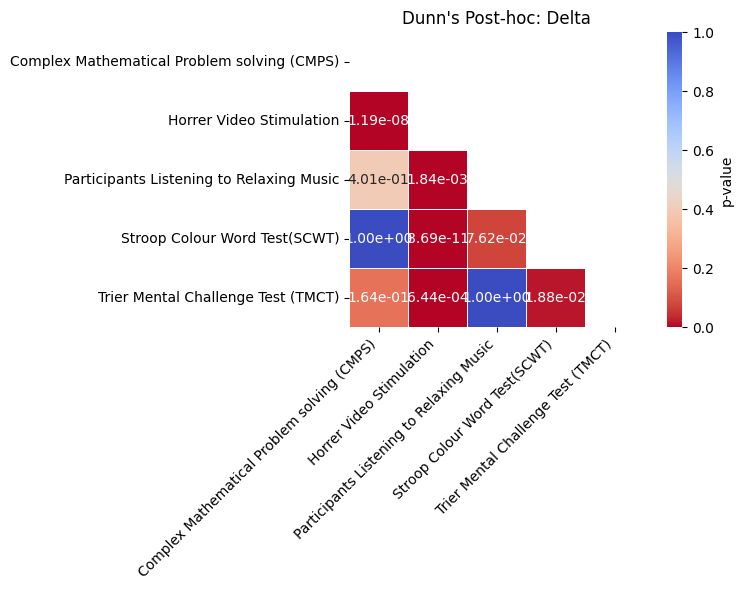

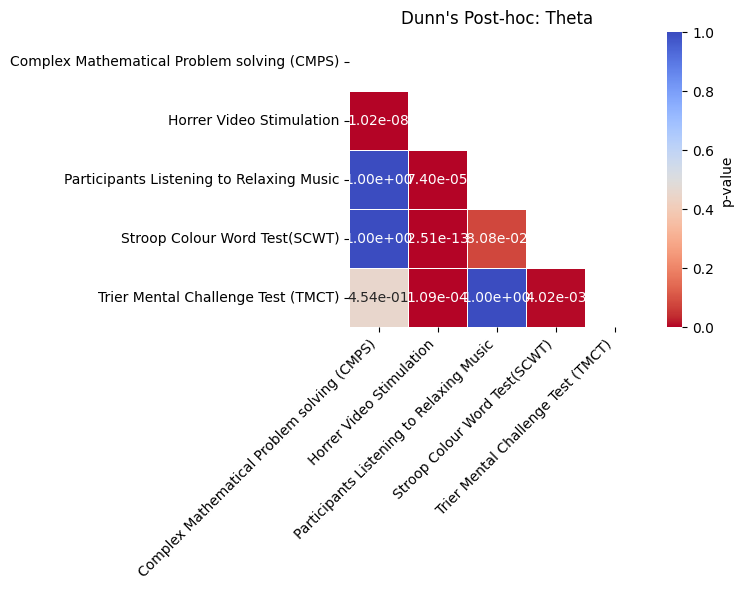

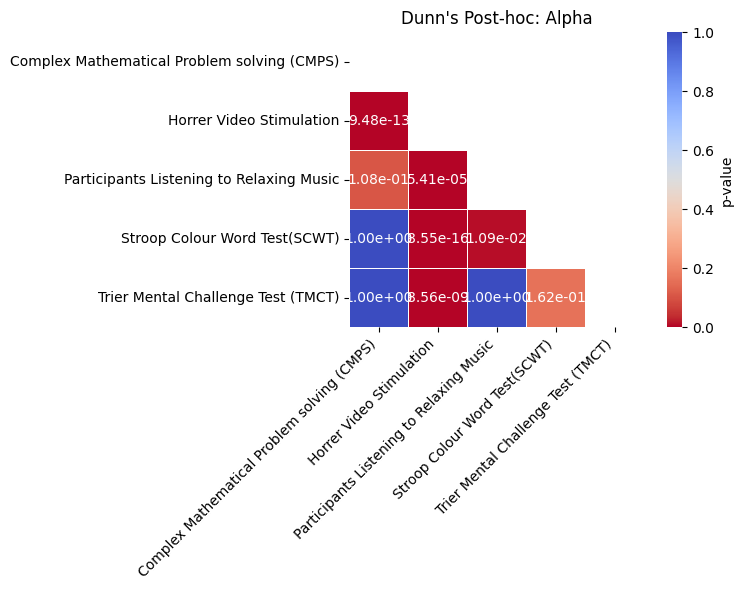

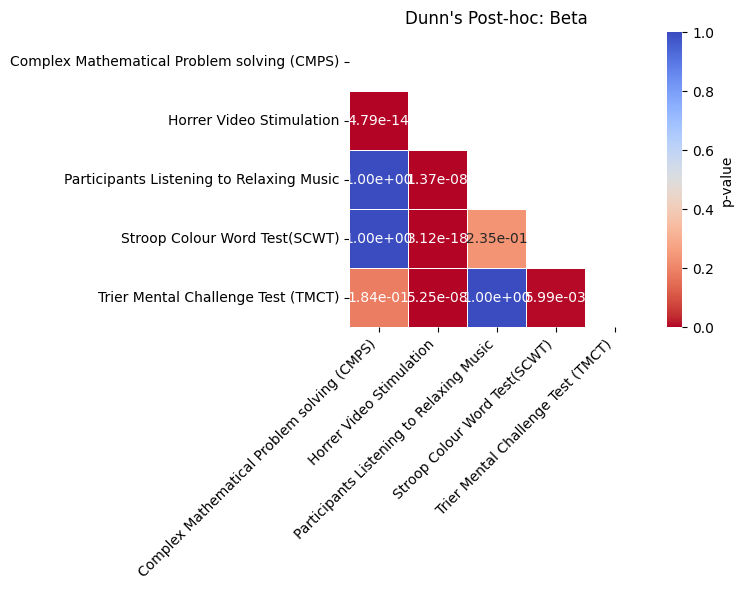

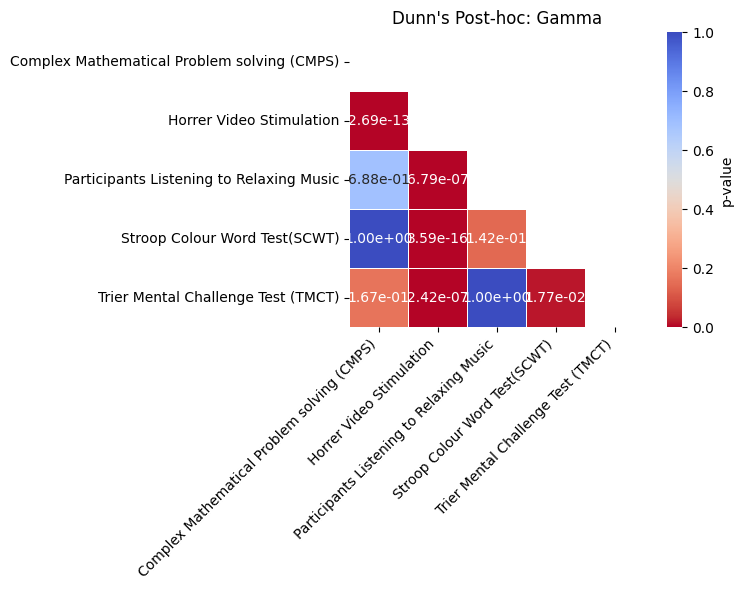

In [ ]:
def plot_dunn_heatmap(dunn_df, title):
    mask = np.triu(np.ones_like(dunn_df, dtype=bool))
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        dunn_df,
        annot=True,
        fmt=".2e",
        cmap="coolwarm_r",
        mask=mask,
        linewidths=0.5,
        cbar_kws={'label': 'p-value'},
        square=True
    )
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
for band in bands:
    if band in dunn_dict:
        plot_dunn_heatmap(dunn_dict[band], f"Dunn's Post-hoc: {band}")

- All five EEG frequency bands (Delta, Theta, Alpha, Beta, Gamma) showed statistically significant differences across scenarios.
- p-values for all bands were < 0.00001, indicating strong global effects of scenario type on brain activity.
-  Horror Video Stimulation:
  - Exhibited the most distinct EEG signature.
  - Significantly different (p < 0.001) from every other scenario in all five bands.
  - Suggests heightened arousal and emotional engagement, especially in Beta and Gamma bands.
- Relaxing Music:
  - Showed significantly higher Alpha and Theta than task-based scenarios.
  - Clear separation from Horror and cognitive tasks — consistent with relaxed, meditative states.
- Cognitive Tasks (CMPS, SCWT, TMCT):
  - Less differentiation between each other, especially CMPS vs TMCT.
  - But still significantly different from emotional scenarios in key bands.
  - SCWT shows distinct differences from Relaxing and Horror in Alpha/Beta.

Explained variance ratio (first 10 PCs):
 PC1: 0.3639
 PC2: 0.1291
 PC3: 0.0792
 PC4: 0.0663
 PC5: 0.0622
 PC6: 0.0532
 PC7: 0.0368
 PC8: 0.0302
 PC9: 0.0291
 PC10: 0.0248


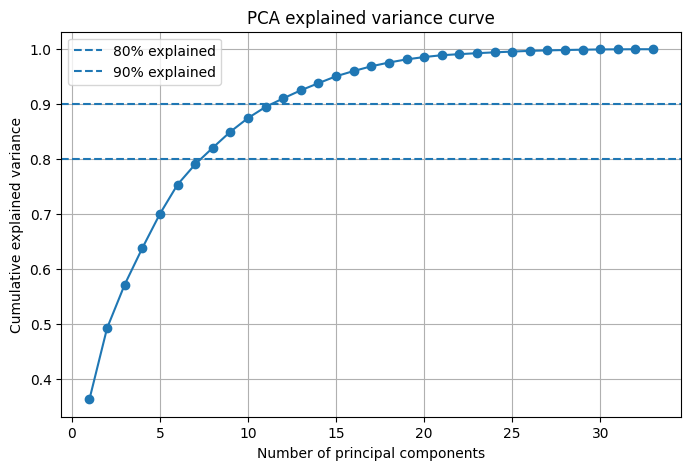

In [ ]:
numeric_df = df_winsorized.select_dtypes(include=[np.number])

X = numeric_df.values.astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_full = PCA(n_components=X_scaled.shape[1])
pca_full.fit(X_scaled)

# 5. Print explained-variance for the first 10 PCs
print("Explained variance ratio (first 10 PCs):")
for i, ratio in enumerate(pca_full.explained_variance_ratio_[:10], start=1):
    print(f" PC{i}: {ratio:.4f}")

# 6. Plot cumulative explained variance
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker='o')
plt.axhline(0.80, linestyle='--', label='80% explained')
plt.axhline(0.90, linestyle='--', label='90% explained')
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance curve")
plt.legend()
plt.grid(True)
plt.show()

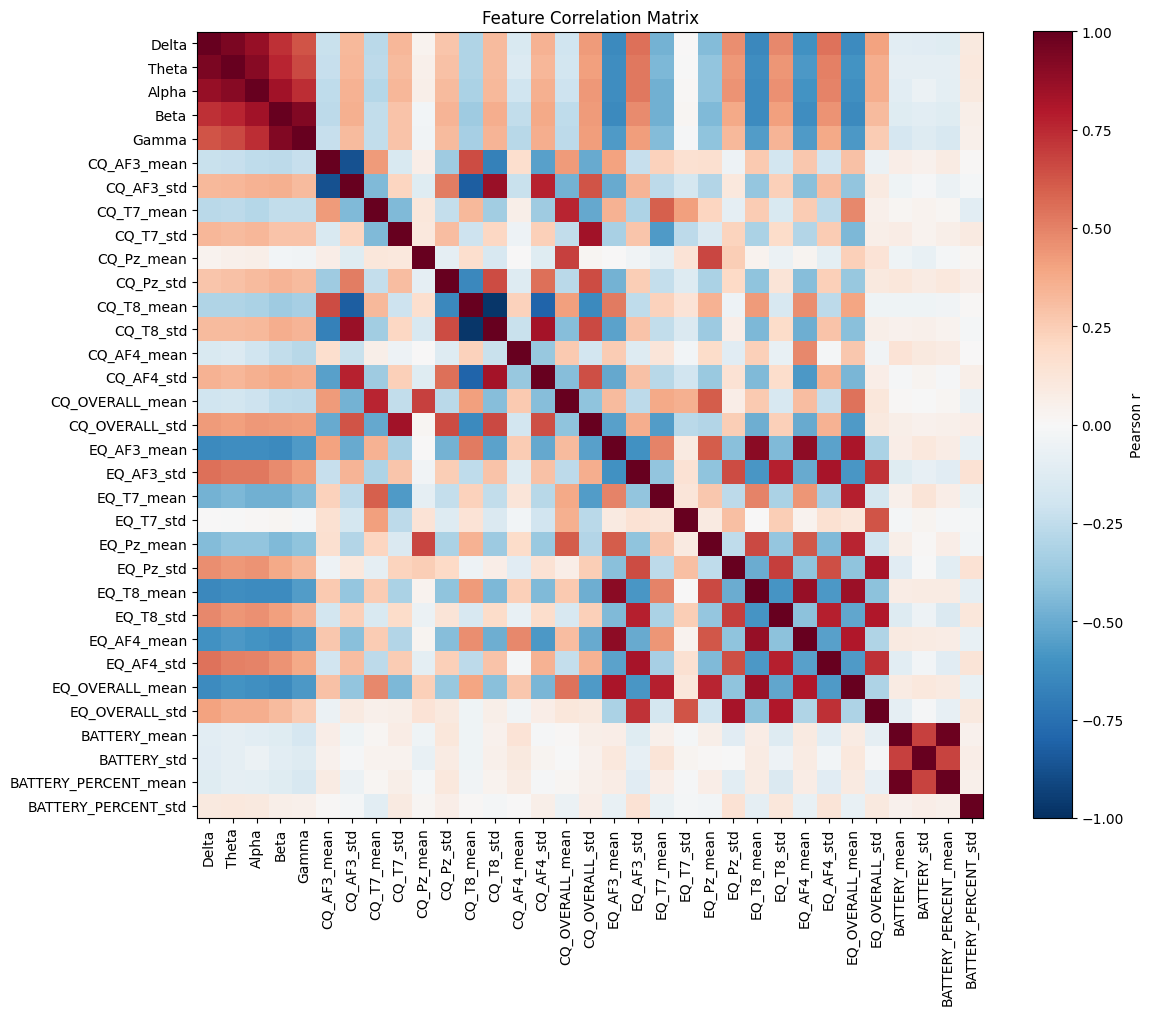

Top 10 |r| >= 0.85:
         feature_1             feature_2         r
523  BATTERY_mean  BATTERY_PERCENT_mean  0.979425
297    CQ_T8_mean             CQ_T8_std -0.974872
0           Delta                 Theta  0.939907
93           Beta                 Gamma  0.929022
32          Theta                 Alpha  0.911722
413   EQ_AF3_mean            EQ_T8_mean  0.904228
415   EQ_AF3_mean           EQ_AF4_mean  0.895019
150   CQ_AF3_mean            CQ_AF3_std -0.874256
1           Delta                 Alpha  0.868011
484    EQ_T8_mean           EQ_AF4_mean  0.867904


In [ ]:
numeric_df = df_winsorized.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(12,10))
plt.imshow(corr, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar(label='Pearson r')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # upper tri
        .stack()
        .reset_index()
)
pairs.columns = ['feature_1','feature_2','r']
top_pairs = pairs.reindex(pairs['r'].abs().sort_values(ascending=False).index)
print("Top 10 |r| >= 0.85:\n", top_pairs[top_pairs['r'].abs()>=0.85].head(10))

In [ ]:
X = numeric_df.values.astype(float)
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=12).fit(X_scaled)

loadings = pd.DataFrame(
    pca.components_.T,
    index=numeric_df.columns,
    columns=[f"PC{i+1}" for i in range(12)]
)

for pc in ['PC1','PC2','PC3']:
    print(f"\nTop features in {pc}:")
    print(loadings[pc].abs().sort_values(ascending=False).head(5))


Top features in PC1:
EQ_OVERALL_mean    0.250061
EQ_AF3_mean        0.248072
EQ_T8_mean         0.242157
EQ_AF4_mean        0.236854
Alpha              0.223588
Name: PC1, dtype: float64

Top features in PC2:
EQ_OVERALL_std    0.335352
EQ_Pz_std         0.289511
EQ_T7_std         0.267878
CQ_T8_std         0.266009
CQ_T8_mean        0.265987
Name: PC2, dtype: float64

Top features in PC3:
BATTERY_mean            0.545577
BATTERY_PERCENT_mean    0.542903
BATTERY_std             0.487463
EQ_OVERALL_std          0.167482
EQ_Pz_std               0.134336
Name: PC3, dtype: float64


In [ ]:
brain_cols   = ['Delta','Theta','Alpha','Beta','Gamma'] \
               + [c for c in df.columns if c.startswith('CQ_')] \
               + [c for c in df.columns if c.startswith('EQ_')]
battery_cols = ['BATTERY_mean', 'BATTERY_std']
meta_cols    = ['Participant','Scenario','Segment','Channel']
Xb = df[brain_cols].astype(float).values
Xb_scaled = StandardScaler().fit_transform(Xb)

pca = PCA(n_components=10).fit(Xb_scaled)
brain_pcs = pca.transform(Xb_scaled)
meta_df = df[meta_cols].reset_index(drop=True)

pc_df = pd.DataFrame(
    brain_pcs,
    columns=[f'Brain_PC{i+1}' for i in range(brain_pcs.shape[1])]
)

batt_df = df[battery_cols].reset_index(drop=True).astype(float)

final_df = pd.concat([meta_df, pc_df, batt_df], axis=1)

final_df.to_csv('/content/drive/MyDrive/output/final_preprocessed_10.csv', index=False)

In [ ]:
brain_cols   = ['Delta','Theta','Alpha','Beta','Gamma'] \
               + [c for c in df.columns if c.startswith('CQ_')] \
               + [c for c in df.columns if c.startswith('EQ_')]
battery_cols = ['BATTERY_mean', 'BATTERY_std']
meta_cols    = ['Participant','Scenario','Segment','Channel']
Xb = df[brain_cols].astype(float).values
Xb_scaled = StandardScaler().fit_transform(Xb)

pca = PCA(n_components=20).fit(Xb_scaled)
brain_pcs = pca.transform(Xb_scaled)
meta_df = df[meta_cols].reset_index(drop=True)

pc_df = pd.DataFrame(
    brain_pcs,
    columns=[f'Brain_PC{i+1}' for i in range(brain_pcs.shape[1])]
)

batt_df = df[battery_cols].reset_index(drop=True).astype(float)

final_df = pd.concat([meta_df, pc_df, batt_df], axis=1)

final_df.to_csv('/content/drive/MyDrive/output/final_preprocessed_20.csv', index=False)

We tried generating the dataframe with different number of components. We ended up using 20 components, since that yielded one of the best results when we trained our model. This is explained thoroughly in the EEG_Model file.